# Event sorting for spikes identified in h5_spikedetector
- Assumes the filename_events.h5 file is in the same folder as this jupyter notebook
- Assumes the events file was generated using h5_spikedetector.ipynb

## User Input

In [2]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
peaksfile = "experiment_C20200330-175336_filtered_64_peaks.csv" # peak times only
eventsfile = "experiment_C20200330-175336_filtered_64_events.csv" # 7ms trace around peak
fs = 30000
chan_num = [0,64]
col_num = 3 # columns per shank
row_num = [22,20,22] # rows per column (# values should == # columns)

## Import Packages

In [3]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd
import scipy 

## Read in the Multichannel event data

In [4]:
peaks = pd.read_csv(peaksfile)
events = pd.read_csv(eventsfile)

## Plot the individual traces by channel (according to probe map)

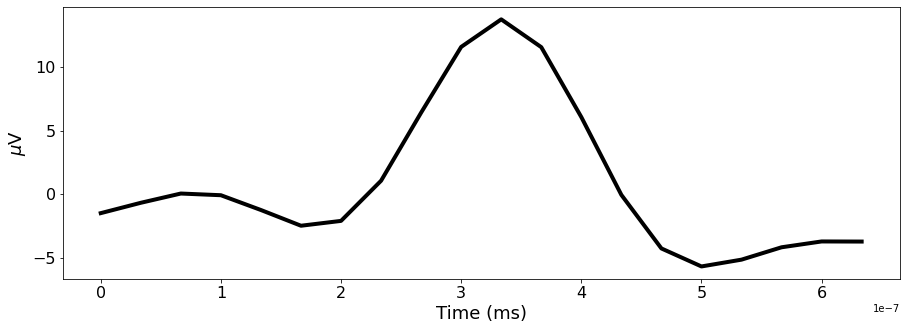

In [5]:
fig, ax = plt.subplots(figsize = (15,5))
x = list(range(0,20))
y_means = []
for chan in list(range(0,chan_num[1])):
    avg_cols = pd.DataFrame({'x':x})
    for col in events.columns:
        if 'yCh'+str(chan) in col:
            avg_cols[col] = events[col] 
    y_mean = avg_cols.transpose().mean()
    y_means.append(y_mean)
    
ax.plot([i/(fs * 1000) for i in x],y_means[0], lw = 4, color = 'black')
ax.set_xlabel('Time (ms)', fontsize = 18)
ax.set_ylabel(r'$\mu$V', fontsize = 18)
ax.tick_params(labelsize = 16)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

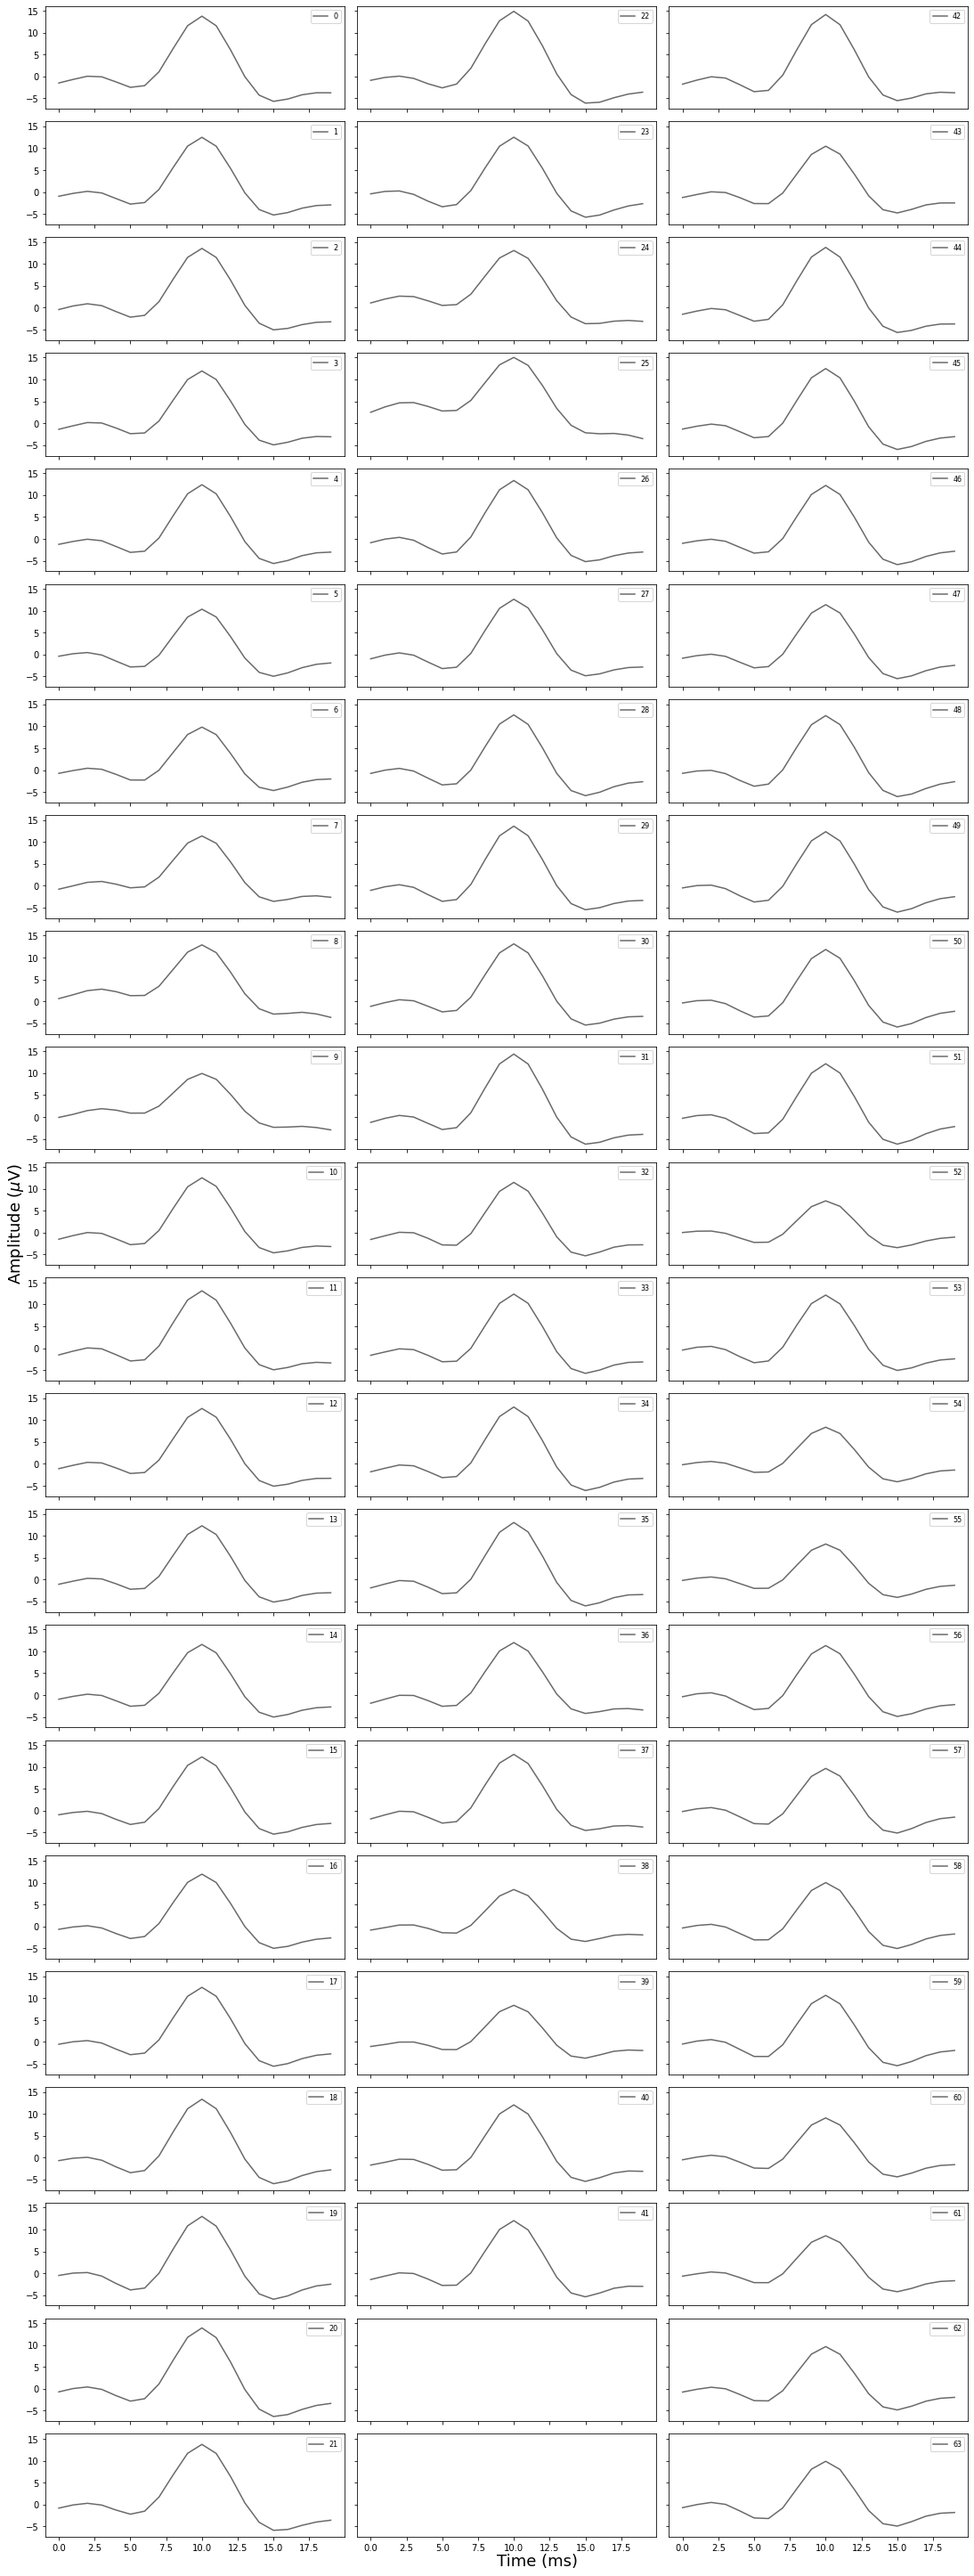

In [6]:
def grid_plot_events(x,y,chans):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (max(row_num),len(row_num), figsize =(15,40), sharex = True, sharey = True)
    x = [i/(fs*1000) for i in x]
    j = 0
    ch_num = 0
    for j in list(range (0,col_num)):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot([i*(fs*1000) for i in x], y_means[ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig (eventsfile.replace('.csv','.png'))
    display(HTML('<hr>'))


grid_plot_events(x, y_means,chan_num[1])

## Get Individual peak widths 
- this one takes a very long time

In [40]:
xs = list(range(0,20))
col_len = len(peaks.index)
print ("Analyzing channel: ")
for chan in range(0,chan_num[1]):
    print(chan, end = ' ')
    x_width = []
    for col in events.columns.values:
        if 'yCh'+str(chan) in col:
            tmp1 = 0
            tmp2 = 0
            for x in range(10,0,-1):
                if events[col][x] < events[col][(x-1)]:
                    tmp1 = x     
            for x in range(11,19):
                if events[col][x] > events[col][(x+1)]:
                    tmp2 = x
            x_width.append(tmp2-tmp1)  
        if len(x_width) < col_len:
            x_width.extend(np.nan for t in range(len(x_width),(col_len))) # Fill in missing values with NaN
        peaks['wCh'+str(chan)] = x_width[:len(peaks.index)]
        

Analyzing channel: 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Get Interevent Intervals

In [91]:
#peaks = peaks.reset_index()
print("Analyzing channel: ", end = ' ')
for chan in list(range(0,chan_num[1])):
    print(chan, end = ' ')
    isi = []
    for col in peaks.columns.values:
        if "xCh"+str(chan) in col:
            i = 0
            for i in range(0,len(peaks[col])-1):
                
                isi.append(peaks[col][(i+1)]-peaks[col][i])
            #print(range(len(isi),len(peaks[col])))
            isi.extend(np.nan for t in range(len(isi),len(peaks[col]))) # Fill in missing values with NaN
            peaks['iCh'+str(chan)] = isi[:len(peaks[col])]    
        


Analyzing channel:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

In [92]:
print(peaks['iCh0'])
#print(peaks.head())

0       26.0
1       15.0
2       11.0
3       24.0
4       24.0
        ... 
1829     NaN
1830     NaN
1831     NaN
1832     NaN
1833     NaN
Name: iCh0, Length: 1834, dtype: float64
